In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold

from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import Normalizer


import torch
from torch import nn
import torch.utils.data
from torch import optim
from torch.utils.data import Dataset
import torch.nn.functional as F

In [2]:
data = pd.read_csv('data/nhanes32006data.csv')

In [3]:
data.head()

,Unnamed: 0,age,agestrat,sex,race,ses,smokehx,bmi,obese,htnhx,...,higlu,hba1c,dm,hf,stroke,mi,fasttime,fast,mortstat,PERMTH_INT
0,1,21.750000,21-35,male,non hispanic black,0.641,yes,25.5,no,hypertensive,...,no,5.3,no,no,no,no,6.52,no,alive,203.0
1,2,32.000000,21-35,female,non hispanic black,4.803,yes,23.4,yes,no,...,no,4.6,no,no,no,no,6.12,no,alive,201.0
2,3,48.583333,35-50,female,hispanic,3.747,no,27.6,yes,no,...,no,5.3,no,no,no,no,13.73,no,alive,201.0
3,4,35.666667,35-50,male,hispanic,5.406,yes,29.4,yes,hypertensive,...,no,4.6,no,no,no,no,15.45,no,alive,196.0
4,5,48.500000,35-50,male,non hispanic black,1.676,no,25.0,no,no,...,yes,9.1,diabetes,no,no,no,1.85,yes,alive,190.0


In [4]:
data.shape

(18414, 33)

In [5]:
required_columns = ['obese', 'uralb', 'trig', 'hdl', 'chol', 'hldhx', 'htnhx', 'sbp', 'dbp', 'bmi', 'smokehx', 'ses', 'race', 'sex', 'age', 'hf', 'stroke', 'mi', 'hba1c']
target = "mortstat"

In [6]:
data[required_columns].dtypes

obese       object
uralb      float64
trig       float64
hdl        float64
chol       float64
hldhx      float64
htnhx       object
sbp        float64
dbp        float64
bmi        float64
smokehx     object
ses        float64
race        object
sex         object
age        float64
hf          object
stroke      object
mi          object
hba1c      float64
dtype: object

In [7]:
data = data[required_columns + [target]]

In [8]:
data.head()

,obese,uralb,trig,hdl,chol,hldhx,htnhx,sbp,dbp,bmi,smokehx,ses,race,sex,age,hf,stroke,mi,hba1c,mortstat
0,no,5.8,174.0,38.0,268.0,1.0,hypertensive,120.0,67.0,25.5,yes,0.641,non hispanic black,male,21.750000,no,no,no,5.3,alive
1,yes,2.2,84.0,55.0,160.0,1.0,no,126.0,86.0,23.4,yes,4.803,non hispanic black,female,32.000000,no,no,no,4.6,alive
2,yes,1.6,98.0,66.0,236.0,2.0,no,131.0,73.0,27.6,no,3.747,hispanic,female,48.583333,no,no,no,5.3,alive
3,yes,8.5,109.0,43.0,225.0,2.0,hypertensive,130.0,82.0,29.4,yes,5.406,hispanic,male,35.666667,no,no,no,4.6,alive
4,no,11.3,94.0,51.0,260.0,1.0,no,120.0,70.0,25.0,no,1.676,non hispanic black,male,48.500000,no,no,no,9.1,alive


In [9]:
data.shape

(18414, 20)

In [10]:
data = data[(data['age'] >= 45 ) & (data['age'] <= 65)]

In [11]:
data.shape

(4545, 20)

Remove patients with mi or hf or stroke

In [12]:
data = data[(data['hf'] != 'yes') & (data['stroke'] != 'yes') & (data['mi'] != 'yes')]
data.shape

(4133, 20)

Read the number of nan values

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4133 entries, 2 to 18407
Data columns (total 20 columns):
obese       3746 non-null object
uralb       3746 non-null float64
trig        3621 non-null float64
hdl         3600 non-null float64
chol        3627 non-null float64
hldhx       4024 non-null float64
htnhx       4114 non-null object
sbp         3741 non-null float64
dbp         3740 non-null float64
bmi         3767 non-null float64
smokehx     4133 non-null object
ses         4133 non-null float64
race        4133 non-null object
sex         4133 non-null object
age         4133 non-null float64
hf          4131 non-null object
stroke      4131 non-null object
mi          4073 non-null object
hba1c       3667 non-null float64
mortstat    4129 non-null object
dtypes: float64(11), object(9)
memory usage: 678.1+ KB


Percentage of missing data

In [14]:
data.isna().any(axis = 1).sum()

738

In [15]:
100*data.isna().any(axis = 1).sum()/data.shape[0]

17.85627873215582

In [16]:
data['hldhx'] = data['hldhx'].astype(object)

In [17]:
categorical_columns = data.select_dtypes('object').columns
categorical_columns

Index(['obese', 'hldhx', 'htnhx', 'smokehx', 'race', 'sex', 'hf', 'stroke',
       'mi', 'mortstat'],
      dtype='object')

In [18]:
numerical_columns = list(set(data.columns) - set(categorical_columns))
numerical_columns

['bmi', 'sbp', 'uralb', 'ses', 'hba1c', 'dbp', 'hdl', 'age', 'trig', 'chol']

Missing data in Categorical Columns

In [19]:
def count_empty(data, columns):
    return data[columns].isna().sum()

Percentage of missing data in each column

In [20]:
def percentage_empty(data, columns):
    return 100*data[columns].isna().sum()/data.shape[0]

In [21]:
percentage_empty(data, categorical_columns)

obese       9.363658
hldhx       2.637309
htnhx       0.459714
smokehx     0.000000
race        0.000000
sex         0.000000
hf          0.048391
stroke      0.048391
mi          1.451730
mortstat    0.096782
dtype: float64

In [22]:
data.loc[data['obese'].isnull(), 'obese'] = "Not_Available"
data.loc[data['htnhx'].isnull(), 'htnhx'] = "Not_Available"
data.loc[data['mi'].isnull(), 'mi'] = "Not_Available"

In [23]:
percentage_empty(data, categorical_columns)

obese       0.000000
hldhx       2.637309
htnhx       0.000000
smokehx     0.000000
race        0.000000
sex         0.000000
hf          0.048391
stroke      0.048391
mi          0.000000
mortstat    0.096782
dtype: float64

In [24]:
count_empty(data, categorical_columns)

obese         0
hldhx       109
htnhx         0
smokehx       0
race          0
sex           0
hf            2
stroke        2
mi            0
mortstat      4
dtype: int64

In [25]:
data['hf'].value_counts(dropna = False)

no     4131
NaN       2
Name: hf, dtype: int64

In [26]:
data['stroke'].value_counts(dropna = False)

no     4131
NaN       2
Name: stroke, dtype: int64

In [27]:
data.loc[data['hf'].isna(), 'hf'] = 'no'
data.loc[data['stroke'].isna(), 'stroke'] = 'no'

In [28]:
data.dropna(subset=['mortstat'], inplace=True)

In [29]:
data.shape

(4129, 20)

In [30]:
count_empty(data, categorical_columns)

obese         0
hldhx       108
htnhx         0
smokehx       0
race          0
sex           0
hf            0
stroke        0
mi            0
mortstat      0
dtype: int64

Missing values in Numeric columns

In [31]:
data[numerical_columns].head()

,bmi,sbp,uralb,ses,hba1c,dbp,hdl,age,trig,chol
2,27.6,131.0,1.6,3.747,5.3,73.0,66.0,48.583333,98.0,236.0
4,25.0,120.0,11.3,1.676,9.1,70.0,51.0,48.500000,94.0,260.0
9,37.0,128.0,0.4,5.690,5.0,73.0,42.0,56.750000,171.0,156.0
12,25.1,117.0,1.8,3.416,5.9,74.0,47.0,50.166667,204.0,244.0
14,37.5,155.0,105.0,0.622,5.7,91.0,30.0,48.416667,479.0,212.0


In [32]:
count_empty(data, numerical_columns)

bmi      364
sbp      390
uralb    385
ses        0
hba1c    464
dbp      391
hdl      531
age        0
trig     510
chol     504
dtype: int64

In [33]:
data[numerical_columns].describe()

,bmi,sbp,uralb,ses,hba1c,dbp,hdl,age,trig,chol
count,3765.000000,3739.000000,3744.000000,4129.000000,3665.000000,3738.000000,3598.000000,4129.000000,3619.000000,3625.000000
mean,28.129907,130.025675,15954.355823,89558.771615,5.820518,78.111557,51.423013,55.011484,165.497099,219.889931
std,5.662946,17.997470,117850.620796,267585.441783,1.334759,9.758558,16.624608,6.005141,138.369686,43.785812
min,13.300000,81.000000,0.400000,0.000000,3.300000,44.000000,12.000000,45.000000,27.000000,59.000000
25%,24.200001,118.000000,2.700000,1.426000,5.200000,72.000000,40.000000,49.750000,92.000000,191.000000
50%,27.200001,128.000000,6.500000,2.812000,5.500000,77.000000,48.000000,55.000000,130.000000,217.000000
75%,31.100000,140.000000,15.200000,4.917000,5.900000,84.000000,60.000000,60.500000,193.000000,245.000000
max,54.299999,237.000000,888888.000000,888888.000000,16.100000,124.000000,191.000000,65.000000,3616.000000,464.000000


In [34]:
data.loc[data['uralb'] == 888888.000, 'uralb'] = np.nan
data.loc[data['ses'] == 888888.000, 'ses'] = np.nan

In [35]:
data[numerical_columns].describe()

,bmi,sbp,uralb,ses,hba1c,dbp,hdl,age,trig,chol
count,3765.000000,3739.000000,3677.000000,3713.000000,3665.000000,3738.000000,3598.000000,4129.000000,3619.000000,3625.000000
mean,28.129907,130.025675,48.303563,2.897925,5.820518,78.111557,51.423013,55.011484,165.497099,219.889931
std,5.662946,17.997470,365.342982,1.977917,1.334759,9.758558,16.624608,6.005141,138.369686,43.785812
min,13.300000,81.000000,0.400000,0.000000,3.300000,44.000000,12.000000,45.000000,27.000000,59.000000
25%,24.200001,118.000000,2.600000,1.302000,5.200000,72.000000,40.000000,49.750000,92.000000,191.000000
50%,27.200001,128.000000,6.300000,2.535000,5.500000,77.000000,48.000000,55.000000,130.000000,217.000000
75%,31.100000,140.000000,14.400000,4.191000,5.900000,84.000000,60.000000,60.500000,193.000000,245.000000
max,54.299999,237.000000,12400.000000,11.290000,16.100000,124.000000,191.000000,65.000000,3616.000000,464.000000


Data shows outliers in trig and uralb

In [36]:
np.nanpercentile(data['trig'], 99)

713.5600000000013

In [37]:
np.nanpercentile(data['uralb'], 99.5)

1768.199999999988

In [38]:
data.loc[data['trig'] > np.nanpercentile(data['trig'], 99), 'trig'] = np.nanpercentile(data['trig'], 99)

In [39]:
data.loc[data['uralb'] > np.nanpercentile(data['uralb'], 99.5), 'uralb'] = np.nanpercentile(data['uralb'], 99.5)

In [40]:
data.describe()

,uralb,trig,hdl,chol,sbp,dbp,bmi,ses,age,hba1c
count,3677.000000,3619.000000,3598.000000,3625.000000,3739.000000,3738.000000,3765.000000,3713.000000,4129.000000,3665.000000
mean,35.421267,162.676353,51.423013,219.889931,130.025675,78.111557,28.129907,2.897925,55.011484,5.820518
std,164.972488,113.660564,16.624608,43.785812,17.997470,9.758558,5.662946,1.977917,6.005141,1.334759
min,0.400000,27.000000,12.000000,59.000000,81.000000,44.000000,13.300000,0.000000,45.000000,3.300000
25%,2.600000,92.000000,40.000000,191.000000,118.000000,72.000000,24.200001,1.302000,49.750000,5.200000
50%,6.300000,130.000000,48.000000,217.000000,128.000000,77.000000,27.200001,2.535000,55.000000,5.500000
75%,14.400000,193.000000,60.000000,245.000000,140.000000,84.000000,31.100000,4.191000,60.500000,5.900000
max,1768.200000,713.560000,191.000000,464.000000,237.000000,124.000000,54.299999,11.290000,65.000000,16.100000


In [41]:
for column in numerical_columns:
    data.loc[data[column].isna(), column] = data[column].mean()

In [42]:
count_empty(data, numerical_columns)

bmi      0
sbp      0
uralb    0
ses      0
hba1c    0
dbp      0
hdl      0
age      0
trig     0
chol     0
dtype: int64

In [43]:
data.columns

Index(['obese', 'uralb', 'trig', 'hdl', 'chol', 'hldhx', 'htnhx', 'sbp', 'dbp',
       'bmi', 'smokehx', 'ses', 'race', 'sex', 'age', 'hf', 'stroke', 'mi',
       'hba1c', 'mortstat'],
      dtype='object')

In [44]:
data['mortstat'].value_counts()

alive    3281
dead      848
Name: mortstat, dtype: int64

Removing Bivariate

In [45]:
data['mortstat'] = data['mortstat'].map({
    'alive' : 0,
    'dead' : 1
})

In [46]:
data['mortstat'].value_counts(normalize = True)

0    0.794623
1    0.205377
Name: mortstat, dtype: float64

In [47]:
categorical_columns = list(categorical_columns)
categorical_columns.remove('mortstat')

In [48]:
data_filtered_cat = pd.get_dummies(data[categorical_columns], drop_first=True)

In [49]:
model_data = pd.concat((data[numerical_columns], data_filtered_cat), axis=1)

In [50]:
model_data.head()

,bmi,sbp,uralb,ses,hba1c,dbp,hdl,age,trig,chol,...,obese_yes,hldhx_2.0,htnhx_hypertensive,htnhx_no,smokehx_yes,race_multiracial,race_non hispanic black,race_non hispanic white,sex_male,mi_no
2,27.6,131.0,1.6,3.747,5.3,73.0,66.0,48.583333,98.0,236.0,...,1,1,0,1,0,0,0,0,0,1
4,25.0,120.0,11.3,1.676,9.1,70.0,51.0,48.500000,94.0,260.0,...,0,0,0,1,0,0,1,0,1,1
9,37.0,128.0,0.4,5.690,5.0,73.0,42.0,56.750000,171.0,156.0,...,1,1,0,1,0,0,0,0,0,1
12,25.1,117.0,1.8,3.416,5.9,74.0,47.0,50.166667,204.0,244.0,...,0,1,0,1,1,0,1,0,1,1
14,37.5,155.0,105.0,0.622,5.7,91.0,30.0,48.416667,479.0,212.0,...,1,0,1,0,0,0,1,0,1,1


In [51]:
model_data.shape

(4129, 21)

In [52]:
data['mortstat'].shape

(4129,)

In [53]:
model_data[:1]

,bmi,sbp,uralb,ses,hba1c,dbp,hdl,age,trig,chol,...,obese_yes,hldhx_2.0,htnhx_hypertensive,htnhx_no,smokehx_yes,race_multiracial,race_non hispanic black,race_non hispanic white,sex_male,mi_no
2,27.6,131.0,1.6,3.747,5.3,73.0,66.0,48.583333,98.0,236.0,...,1,1,0,1,0,0,0,0,0,1


In [54]:
model_data = Normalizer().fit_transform(model_data)

In [55]:
model_data[:1]

array([[0.08939729, 0.42431325, 0.00518245, 0.01213665, 0.01716687,
        0.23644937, 0.21377614, 0.15736299, 0.31742518, 0.76441165,
        0.        , 0.00323903, 0.00323903, 0.        , 0.00323903,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00323903]])

In [56]:
y = data['mortstat'].values

Split data into train and test

In [57]:
train_x, val_x, train_y, val_y = train_test_split(model_data, y, test_size = 0.3, random_state = 10)

In [58]:
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size = 0.3, random_state = 10)

In [59]:
print(train_x.shape, val_x.shape, test_x.shape, train_y.shape, val_y.shape, test_y.shape)

(2023, 21) (1239, 21) (867, 21) (2023,) (1239,) (867,)


In [60]:
train_x = torch.FloatTensor(train_x)
train_y = torch.LongTensor(train_y)
val_x = torch.FloatTensor(val_x)
val_y = torch.LongTensor(val_y)
test_x = torch.FloatTensor(test_x)
test_y = torch.LongTensor(test_y)

In [61]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        super(MyDataset, self).__init__()
        assert x.shape[0] == y.shape[0]
        self.x = x
        self.y = y
        
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, index):   
        return self.x[index], self.y[index]

In [62]:
traindata = MyDataset(train_x, train_y)
valdata = MyDataset(val_x, val_y)
testdata = MyDataset(test_x, test_y)

In [63]:
trainloader = torch.utils.data.DataLoader(traindata, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valdata, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=True)

In [64]:
len(testloader)

14

In [65]:
# model = nn.Sequential(nn.Linear(21, 64),
#                       nn.ReLU(),
#                       nn.Linear(64, 16),
#                       nn.ReLU(),
#                       nn.Linear(16, 2),
#                       nn.LogSoftmax(dim=1))


model = nn.Sequential(nn.Linear(21, 64),
                      nn.ReLU(),
                      nn.Linear(64, 16),
                      nn.ReLU(),
                      nn.Linear(16, 2),
                      nn.LogSoftmax(dim=1))

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(21, 64)
#         self.fc2 = nn.Linear(64, 16)
#         self.fc3 = nn.Linear(16,2)
#         self.softmax = nn.LogSoftmax(dim=1)
#         self.drop = nn.Dropout(p=0.0)

#     def forward(self, x):
#         # flatten image input
#         x = F.relu(self.fc1(x))
#         x = self.drop(x)
#         x = F.relu(self.fc2(x))
#         x = self.drop(x)
#         x = F.relu(self.fc3(x))
#         return self.softmax(x)
    
# model = Net()

In [66]:
model

Sequential(
  (0): Linear(in_features=21, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=2, bias=True)
  (5): LogSoftmax()
)

In [67]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 50
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    model.train()
    for vitals, mortstat in trainloader:
        optimizer.zero_grad()
        
        log_ps = model(vitals)
        loss = criterion(log_ps, mortstat)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            model.eval()
            for vitals, mortstat in valloader:
                log_ps = model(vitals)
                test_loss += criterion(log_ps, mortstat).item()
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == mortstat.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(valloader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(valloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(valloader)))

Epoch: 1/50..  Training Loss: 0.523..  Test Loss: 0.511..  Test Accuracy: 0.792
Epoch: 2/50..  Training Loss: 0.490..  Test Loss: 0.514..  Test Accuracy: 0.786
Epoch: 3/50..  Training Loss: 0.487..  Test Loss: 0.515..  Test Accuracy: 0.785
Epoch: 4/50..  Training Loss: 0.486..  Test Loss: 0.506..  Test Accuracy: 0.788
Epoch: 5/50..  Training Loss: 0.480..  Test Loss: 0.503..  Test Accuracy: 0.786
Epoch: 6/50..  Training Loss: 0.476..  Test Loss: 0.499..  Test Accuracy: 0.792
Epoch: 7/50..  Training Loss: 0.478..  Test Loss: 0.498..  Test Accuracy: 0.789
Epoch: 8/50..  Training Loss: 0.473..  Test Loss: 0.507..  Test Accuracy: 0.793
Epoch: 9/50..  Training Loss: 0.473..  Test Loss: 0.496..  Test Accuracy: 0.790
Epoch: 10/50..  Training Loss: 0.470..  Test Loss: 0.495..  Test Accuracy: 0.786
Epoch: 11/50..  Training Loss: 0.470..  Test Loss: 0.488..  Test Accuracy: 0.791
Epoch: 12/50..  Training Loss: 0.472..  Test Loss: 0.495..  Test Accuracy: 0.791
Epoch: 13/50..  Training Loss: 0.467.

In [68]:
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval() # prep model for evaluation

for data, target in testloader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.474905

Test Accuracy of     0: 99% (673/679)
Test Accuracy of     1: 10% (20/188)

Test Accuracy (Overall): 79% (693/867)


In [69]:
ps = torch.exp(model(test_x))
top_p, top_class = ps.topk(1, dim=1)

In [70]:
test_pred = top_class.squeeze()

In [71]:
test_y[:10]

tensor([1, 0, 0, 1, 1, 0, 0, 0, 0, 0])

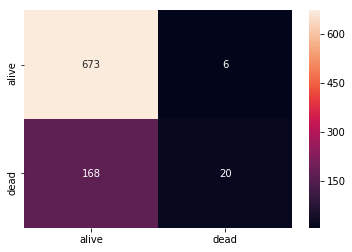

In [72]:
import seaborn as sns
sns.heatmap(confusion_matrix(test_y, test_pred), annot=True , fmt='', xticklabels=['alive','dead'], yticklabels=['alive','dead'])

In [73]:
print(classification_report(test_y,test_pred))

              precision    recall  f1-score   support

           0       0.80      0.99      0.89       679
           1       0.77      0.11      0.19       188

   micro avg       0.80      0.80      0.80       867
   macro avg       0.78      0.55      0.54       867
weighted avg       0.79      0.80      0.73       867



In [74]:
accuracy_score(y_true=test_y, y_pred=test_pred)

0.7993079584775087